# 预测摄像头实时画面

使用训练好的图像分类模型，对视频文件进行逐帧预测。

本代码需在`连接摄像头的本地`运行，不能在云GPU平台运行。

测试运行环境：Macbook Pro

同济子豪兄：https://space.bilibili.com/1900783

## 导入工具包

In [1]:
import os

import numpy as np
import pandas as pd

import cv2 # opencv-python
from PIL import Image, ImageFont, ImageDraw
from tqdm import tqdm # 进度条

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn.functional as F
from torchvision import models

D:\Software\anaconda\envs\Pytorch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda:0


## 导入中文字体

In [3]:
# 下载中文字体文件
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

In [3]:
# 导入中文字体，指定字号
font = ImageFont.truetype('SimHei.ttf', 20)

## 载入类别

In [4]:
idx_to_labels = np.load(r'E:\MV-Code-202018010103-Lucy\main\Train_Custom_Dataset\图像分类\3-【Pytorch】迁移学习训练自己的图像分类模型\idx_to_labels.npy', allow_pickle=True).item()

In [5]:
idx_to_labels

{0: 'parasitized', 1: 'uninfected'}

## 导入训练好的模型

In [6]:
model = torch.load( r'E:\MV-Code-202018010103-Lucy\main\Train_Custom_Dataset\图像分类\3-【Pytorch】迁移学习训练自己的图像分类模型\checkpoint\best-1.000.pth')
model = model.eval().to(device)

## 图像预处理

In [7]:
from torchvision import transforms

# 测试集图像预处理-RCTN：缩放裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 获取摄像头的一帧画面

In [8]:
# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

time.sleep(1)

success, img_bgr = cap.read()
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

In [38]:
img_bgr.shape

(480, 640, 3)

In [39]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR转RGB

In [40]:
img_pil = Image.fromarray(img_rgb)

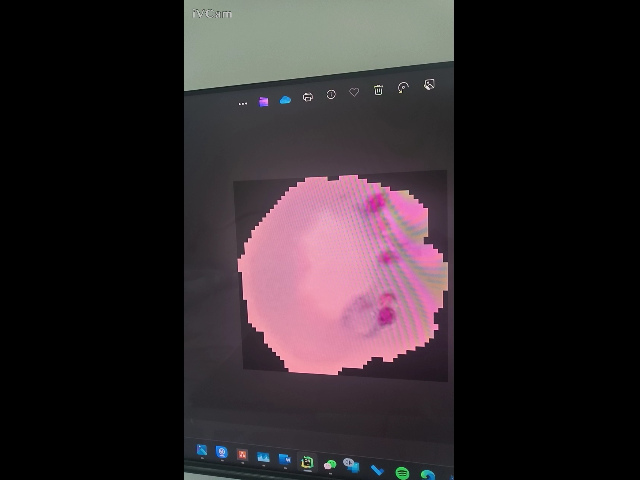

In [41]:
img_pil

In [42]:
input_img = test_transform(img_pil).unsqueeze(0).to(device) # 预处理
pred_logits = model(input_img) # 执行前向预测，得到所有类别的 logit 预测分数
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

n = 2
top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果
pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出类别
confs = top_n[0].cpu().detach().numpy().squeeze() # 解析出置信度

In [43]:
draw = ImageDraw.Draw(img_pil) 
# 在图像上写字
for i in range(len(confs)):
    pred_class = idx_to_labels[pred_ids[i]]
    text = '{:<15} {:>.3f}'.format(pred_class, confs[i])
    # 文字坐标，中文字符串，字体，rgba颜色
    draw.text((50, 100 + 50 * i), text, font=font, fill=(255, 0, 0, 1))
img = np.array(img_pil) # PIL 转 array

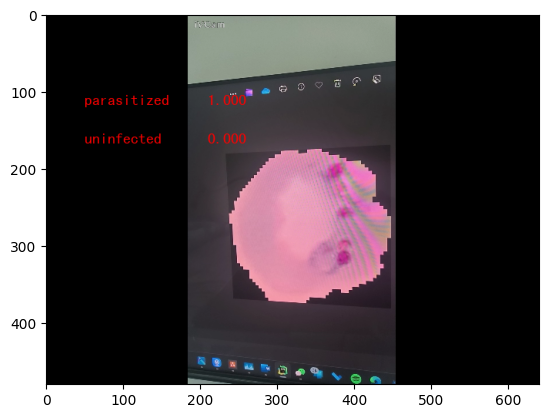

In [44]:
plt.imshow(img)
plt.show()

## 处理单帧画面的函数（中文）

In [10]:
# 处理帧函数
def process_frame(img):
    
    # 记录该帧开始处理的时间
    start_time = time.time()
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR转RGB
    img_pil = Image.fromarray(img_rgb) # array 转 PIL
    input_img = test_transform(img_pil).unsqueeze(0).to(device) # 预处理
    pred_logits = model(input_img) # 执行前向预测，得到所有类别的 logit 预测分数
    pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算
    
    top_n = torch.topk(pred_softmax, 2) # 取置信度最大的 n 个结果
    pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析预测类别
    confs = top_n[0].cpu().detach().numpy().squeeze() # 解析置信度
    
    # 使用PIL绘制中文
    draw = ImageDraw.Draw(img_pil) 
    # 在图像上写字
    for i in range(len(confs)):
        pred_class = idx_to_labels[pred_ids[i]]
        text = '{:<15} {:>.3f}'.format(pred_class, confs[i])
        # 文字坐标，中文字符串，字体，bgra颜色
        draw.text((50, 100 + 50 * i),  text, font=font, fill=(255, 0, 0, 1))
    img = np.array(img_pil) # PIL 转 array
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # RGB转BGR
    
    # 记录该帧处理完毕的时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1/(end_time - start_time)  
    # 图片，添加的文字，左上角坐标，字体，字体大小，颜色，线宽，线型
    img = cv2.putText(img, 'FPS  '+str(int(FPS)), (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 255), 4, cv2.LINE_AA)
    return img

## 调用摄像头获取每帧（模板）

In [11]:
# 调用摄像头逐帧实时处理模板
# 不需修改任何代码，只需修改process_frame函数即可
# 同济子豪兄 2021-7-8

# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

# 无限循环，直到break被触发
while cap.isOpened():
    # 获取画面
    success, frame = cap.read()
    if not success:
        print('Error')
        break
    
    ## !!!处理帧函数
    frame = process_frame(frame)
    
    # 展示处理后的三通道图像
    cv2.imshow('my_window',frame)

    if cv2.waitKey(1) in [ord('q'),27]: # 按键盘上的q或esc退出（在英文输入法下）
        break
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [ ]:
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()